Run thi sonly once this is to unzip the images for preocessing

In [1]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: tinyface/Training_Set/2898/2898_1.jpg  
  inflating: tinyface/Training_Set/2898/2898_2.jpg  
  inflating: tinyface/Training_Set/2899/2899_1.jpg  
  inflating: tinyface/Training_Set/2899/2899_2.jpg  
  inflating: tinyface/Training_Set/2900/2900_1.jpg  
  inflating: tinyface/Training_Set/2900/2900_2.jpg  
  inflating: tinyface/Training_Set/2900/2900_3.jpg  
  inflating: tinyface/Training_Set/2902/2902_1.jpg  
  inflating: tinyface/Training_Set/2902/2902_2.jpg  
  inflating: tinyface/Training_Set/2903/2903_1.jpg  
  inflating: tinyface/Training_Set/2903/2903_2.jpg  
  inflating: tinyface/Training_Set/2904/2904_1.jpg  
  inflating: tinyface/Training_Set/2904/2904_2.jpg  
  inflating: tinyface/Training_Set/2904/2904_3.jpg  
  inflating: tinyface/Training_Set/2905/2905_1.jpg  
  inflating: tinyface/Training_Set/2905/2905_2.jpg  
  inflating: tinyface/Training_Set/2905/2905_3.jpg  
  inflating: tinyface/Training_Set/2905/2905_4.j

**Importing some important Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import random as rand
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import os
import cv2
from math import log10, sqrt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.utils import to_categorical

**Reading Data from Training Folders**

In [ ]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/tinyface/Training_Set/'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        i = rand.randint(0, 5000)%100
        if i <= 5:
          Result_Training.append(0)
        else:
          Result_Training.append(1)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

((7804, 32, 32, 3), (7804,))

In [ ]:
Testing = []
Result_Testing = []
for dirname, _, filenames in os.walk('/content/tinyface/Testing_Set/Gallery_Match'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        i = rand.randint(0, 5000)%100
        if i <= 5:
          Result_Testing.append(0)
        else:
          Result_Testing.append(1)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        Testing.append(img)
np.array(Testing).shape, np.array(Result_Testing).shape

((4443, 32, 32, 3), (4443,))

CrossChecking Images we READ from the Folder

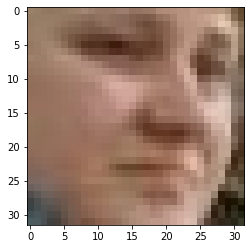

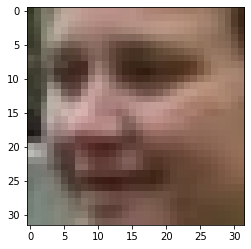

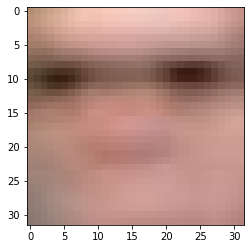

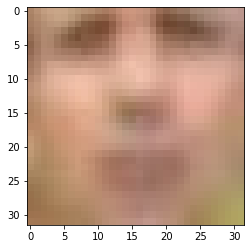

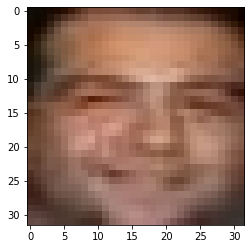

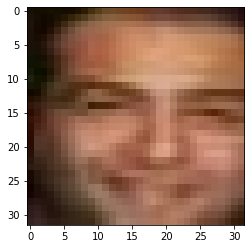

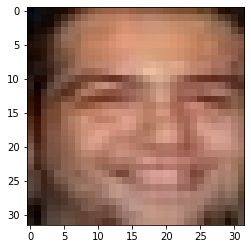

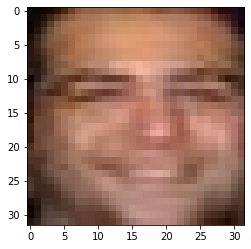

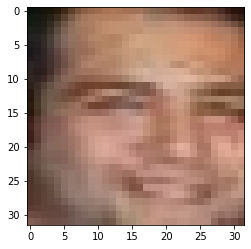

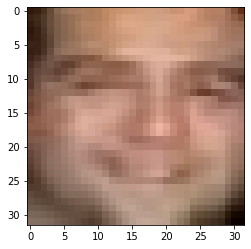

In [ ]:
for i in range(10):
    plt.imshow(Training[i])
    plt.show()

# LOADING U-NET GAN (SRGAN) for SUPER-RESOLUTION

In [ ]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/LapSRN_x4.pb')
super_res.setModel('lapsrn',4)

Printing Sample

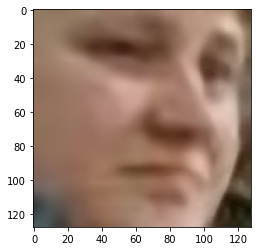

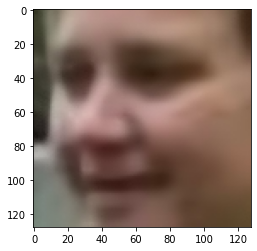

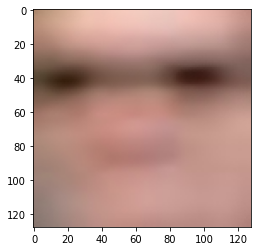

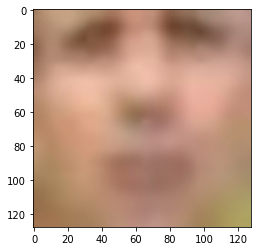

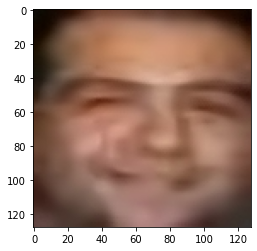

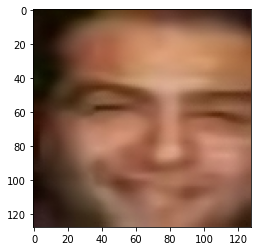

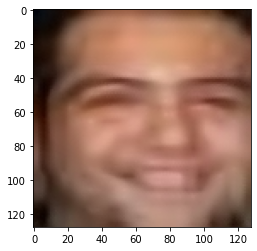

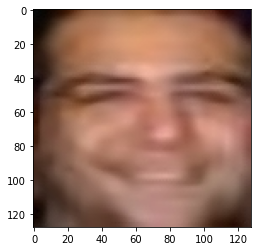

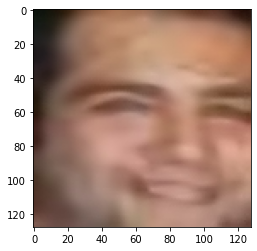

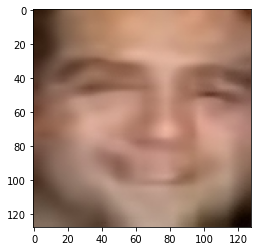

In [ ]:
for i in range(10):
  plt.imshow(super_res.upsample(Training[i]))
  plt.show()

# UPSAMPLING ALL THE DATA

In [ ]:
Temp_Train = []
for i in Training:
  img = super_res.upsample(i)
  print(".", end="")
  Temp_Train.append(img)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
Temp_Test = []
for i in Testing:
  img = super_res.upsample(i)
  print(".", end="")
  Temp_Test.append(img)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

**PSNR** for the Converision

In [12]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

Making Files the Same dimention for colculation

In [ ]:
test = []
for i in Training:
  img = cv2.resize(i, (32*4, 32*4))
  test.append(img)
np.array(test).shape

(7804, 128, 128, 3)

In [ ]:
Result = Result_Training
Result.extend(Result_Testing)
np.array(Result).shape

(12247,)

In [ ]:
PSNR(np.array(test), np.array(Temp_Train))

39.92699177646297

# Train and Test Data are Totaly Diferent SO merging and then Sipliting Might be helpfull

In [ ]:
Training = Temp_Train
Training.extend(Temp_Test)
np.array(Training).shape

(12247, 128, 128, 3)

In [ ]:
Temp = []
for i in Result:
  temp = [i]
  Temp.append(temp)
output_matrix = to_categorical(np.array(Temp))
total = output_matrix.shape[1]
output_matrix.shape

(12247, 2)

# Sipliting Data for Training and Testing

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Training), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape 

((11022, 128, 128, 3), (1225, 128, 128, 3))

## RESIDUAL NETWORK 50 MODEL ResNet50

In [ ]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 27,788,162
Trainable params: 4,200,450
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
X_train.shape, Y_train.shape

((11022, 128, 128, 3), (11022, 2))

Trainng of Model

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
345/345 [==============================] - 23s 35ms/step - loss: 0.4025 - accuracy: 0.9289
Epoch 2/10
345/345 [==============================] - 12s 34ms/step - loss: 0.2402 - accuracy: 0.9362
Epoch 3/10
345/345 [==============================] - 12s 34ms/step - loss: 0.2311 - accuracy: 0.9359
Epoch 4/10
345/345 [==============================] - 12s 34ms/step - loss: 0.2234 - accuracy: 0.9364
Epoch 5/10
345/345 [==============================] - 12s 35ms/step - loss: 0.2168 - accuracy: 0.9387
Epoch 6/10
345/345 [==============================] - 12s 34ms/step - loss: 0.2032 - accuracy: 0.9408
Epoch 7/10
345/345 [==============================] - 12s 35ms/step - loss: 0.1862 - accuracy: 0.9437
Epoch 8/10
345/345 [==============================] - 12s 35ms/step - loss: 0.1694 - accuracy: 0.9469
Epoch 9/10
345/345 [==============================] - 12s 34ms/step - loss: 0.1555 - accuracy: 0.9520
Epoch 10/10
345/345 [==============================] - 12s 35ms/step - loss: 0.138

# Plotting LOSS AND ACC

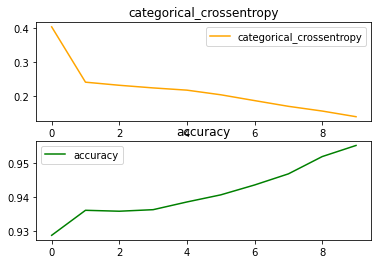

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

# MAKING PREDICTIONS AND THEN CHECKING THEM

In [ ]:
pre = resnet_model.predict(X_test)

39/39 [==============================] - 2s 42ms/step


In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

**Confussion Metrice**

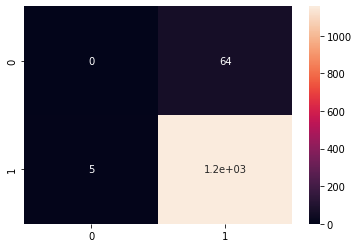

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

# ACC of your Model ->(ResNet using U-Net Gan)

In [ ]:
accuracy_score(y_real, y_pre)

0.9436734693877551

# MODEL OF MOBILEv2

In [ ]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


**SAME, EASY AND BASIC CODE AS DONE EARLIER**

In [ ]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
345/345 [==============================] - 9s 16ms/step - loss: 0.2936 - accuracy: 0.9342
Epoch 2/10
345/345 [==============================] - 6s 17ms/step - loss: 0.2425 - accuracy: 0.9362
Epoch 3/10
345/345 [==============================] - 5s 16ms/step - loss: 0.2401 - accuracy: 0.9362
Epoch 4/10
345/345 [==============================] - 6s 16ms/step - loss: 0.2398 - accuracy: 0.9362
Epoch 5/10
345/345 [==============================] - 6s 17ms/step - loss: 0.2386 - accuracy: 0.9362
Epoch 6/10
345/345 [==============================] - 5s 16ms/step - loss: 0.2373 - accuracy: 0.9362
Epoch 7/10
345/345 [==============================] - 6s 17ms/step - loss: 0.2375 - accuracy: 0.9363
Epoch 8/10
345/345 [==============================] - 5s 16ms/step - loss: 0.2359 - accuracy: 0.9364
Epoch 9/10
345/345 [==============================] - 6s 17ms/step - loss: 0.2354 - accuracy: 0.9362
Epoch 10/10
345/345 [==============================] - 5s 15ms/step - loss: 0.2342 - accura

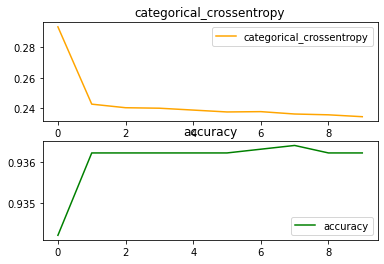

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
pre = mobile_model.predict(X_test)

39/39 [==============================] - 2s 23ms/step


In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

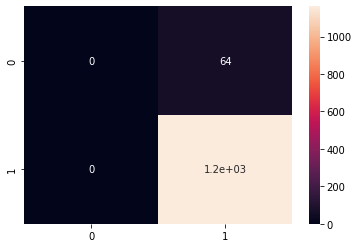

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
accuracy_score(y_real, y_pre)

0.9477551020408164

# Loading DATASET for it to Enhanced by the OTHER RS-MODEL

In [3]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/tinyface/Training_Set/'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        i = rand.randint(0, 5000)%100
        if i <= 5:
          Result_Training.append(0)
        else:
          Result_Training.append(1)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

((7804, 32, 32, 3), (7804,))

In [4]:
Testing = []
Result_Testing = []
for dirname, _, filenames in os.walk('/content/tinyface/Testing_Set/Gallery_Match'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        i = rand.randint(0, 5000)%100
        if i <= 5:
          Result_Testing.append(0)
        else:
          Result_Testing.append(1)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        Testing.append(img)
np.array(Testing).shape, np.array(Result_Testing).shape

((4443, 32, 32, 3), (4443,))

In [5]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/EDSR_x3.pb')
super_res.setModel('edsr',3)

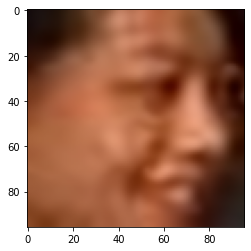

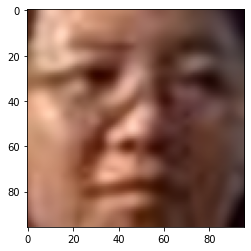

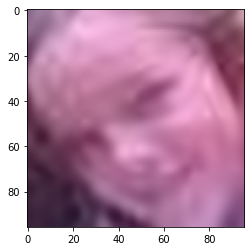

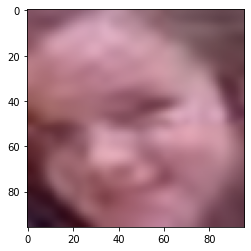

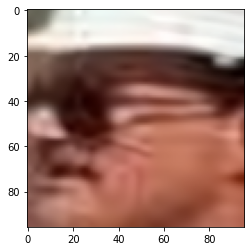

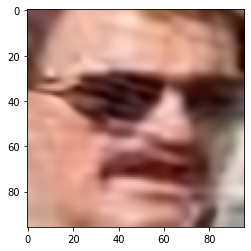

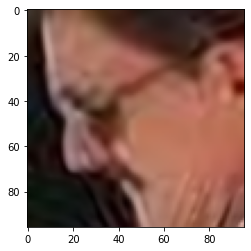

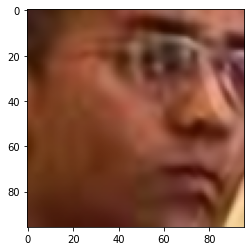

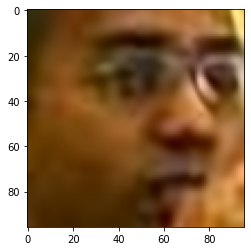

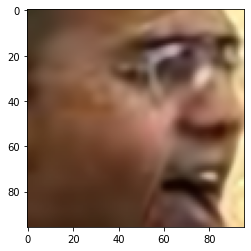

In [6]:
for i in range(10):
  plt.imshow(super_res.upsample(Training[i]))
  plt.show()

In [7]:
Temp_Train = []
for i in Training[:1000]:
  img = super_res.upsample(i)
  print(".", end="")
  Temp_Train.append(img)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
Temp_Test = []
for i in Testing[:1000]:
  img = super_res.upsample(i)
  print(".", end="")
  Temp_Test.append(img)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
test = []
for i in Training:
  img = cv2.resize(i, (32*3, 32*3))
  test.append(img)
np.array(test).shape

(7804, 96, 96, 3)

In [10]:
Result = Result_Training[:1000]
Result.extend(Result_Testing[:1000])
np.array(Result).shape

(2000,)

In [13]:
PSNR(np.array(test[:1000]), np.array(Temp_Train))

40.015505638762576

In [14]:
Training = Temp_Train
Training.extend(Temp_Test)
np.array(Training).shape

(2000, 96, 96, 3)

In [15]:
Temp = []
for i in Result:
  temp = [i]
  Temp.append(temp)
output_matrix = to_categorical(np.array(Temp))
total = output_matrix.shape[1]
output_matrix.shape

(2000, 2)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Training), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape 

((1800, 96, 96, 3), (200, 96, 96, 3))

# ResNet50 MODEL

In [17]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32*3, 32*3, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 27,788,162
Trainable params: 4,200,450
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
57/57 [==============================] - 14s 30ms/step - loss: 0.9733 - accuracy: 0.9211
Epoch 2/10
57/57 [==============================] - 1s 24ms/step - loss: 0.1975 - accuracy: 0.9439
Epoch 3/10
57/57 [==============================] - 1s 26ms/step - loss: 0.1775 - accuracy: 0.9500
Epoch 4/10
57/57 [==============================] - 1s 26ms/step - loss: 0.1350 - accuracy: 0.9572
Epoch 5/10
57/57 [==============================] - 1s 25ms/step - loss: 0.1119 - accuracy: 0.9656
Epoch 6/10
57/57 [==============================] - 1s 24ms/step - loss: 0.0718 - accuracy: 0.9733
Epoch 7/10
57/57 [==============================] - 1s 25ms/step - loss: 0.0699 - accuracy: 0.9778
Epoch 8/10
57/57 [==============================] - 1s 25ms/step - loss: 0.0464 - accuracy: 0.9833
Epoch 9/10
57/57 [==============================] - 1s 25ms/step - loss: 0.0283 - accuracy: 0.9917
Epoch 10/10
57/57 [==============================] - 1s 25ms/step - loss: 0.0284 - accuracy: 0.9911


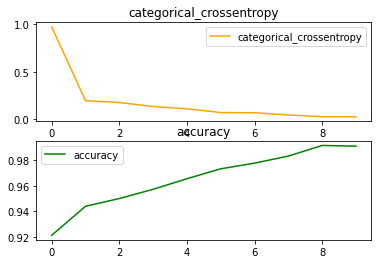

In [20]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [21]:
pre = resnet_model.predict(X_test)

7/7 [==============================] - 1s 33ms/step


In [22]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

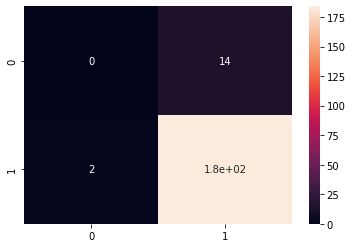

In [23]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [24]:
accuracy_score(y_real, y_pre)

0.92

# MobileNetv2 model

In [25]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(32*3, 32*3, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [26]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
57/57 [==============================] - 5s 17ms/step - loss: 0.4729 - accuracy: 0.9344
Epoch 2/10
57/57 [==============================] - 1s 13ms/step - loss: 0.2165 - accuracy: 0.9450
Epoch 3/10
57/57 [==============================] - 1s 13ms/step - loss: 0.2070 - accuracy: 0.9444
Epoch 4/10
57/57 [==============================] - 1s 11ms/step - loss: 0.2015 - accuracy: 0.9450
Epoch 5/10
57/57 [==============================] - 1s 18ms/step - loss: 0.1978 - accuracy: 0.9450
Epoch 6/10
57/57 [==============================] - 1s 14ms/step - loss: 0.2054 - accuracy: 0.9439
Epoch 7/10
57/57 [==============================] - 1s 11ms/step - loss: 0.1976 - accuracy: 0.9439
Epoch 8/10
57/57 [==============================] - 1s 11ms/step - loss: 0.1874 - accuracy: 0.9450
Epoch 9/10
57/57 [==============================] - 1s 11ms/step - loss: 0.1926 - accuracy: 0.9456
Epoch 10/10
57/57 [==============================] - 1s 11ms/step - loss: 0.1752 - accuracy: 0.9472


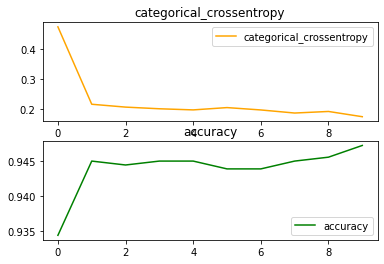

In [27]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [28]:
pre = mobile_model.predict(X_test)

7/7 [==============================] - 1s 13ms/step


In [29]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

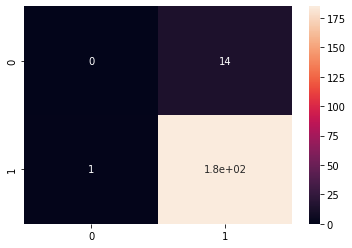

In [30]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [31]:
accuracy_score(y_real, y_pre)

0.925